In [225]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

stocks = 'AAPL'
start = datetime.datetime(2000, 1, 3)
end = datetime.datetime(2013, 11, 30)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')


log_ret = np.log(s_p500['Adj Close'])
ret = (log_ret.pct_change()[1:])

[*********************100%%**********************]  1 of 1 completed


In [226]:
double = ret ** 2
realized_vol = double.rolling(5).sum()/5
realized_vol
realized_vol = np.sqrt(realized_vol)
realized_vol

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10    0.089203
                ...   
2013-11-22    0.000010
2013-11-25    0.000007
2013-11-26    0.000016
2013-11-27    0.000027
2013-11-29    0.000032
Name: Adj Close, Length: 3499, dtype: float64

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10    0.298669
                ...   
2013-11-22    0.003110
2013-11-25    0.002710
2013-11-26    0.003976
2013-11-27    0.005244
2013-11-29    0.005677
Name: Adj Close, Length: 3499, dtype: float64

In [227]:
n = 500
split_date = ret.iloc[-n:].index

In [228]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV


In [229]:
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [230]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)


In [231]:
X

,0,1
0,NaN,2.778764e-01
1,NaN,3.241369e-03
2,NaN,1.414847e-01
3,NaN,1.953284e-02
4,0.298669,3.880071e-03
...,...,...
3494,0.003110,8.510575e-07
3495,0.002710,7.334582e-06
3496,0.003976,4.272961e-05
3497,0.005244,6.839646e-05


In [232]:
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [233]:
X

,0,1
0,0.298669,3.880071e-03
1,0.199120,3.010492e-02
2,0.212289,3.033075e-02
3,0.170963,6.229333e-02
4,0.167869,1.429126e-02
...,...,...
3490,0.003110,8.510575e-07
3491,0.002710,7.334582e-06
3492,0.003976,4.272961e-05
3493,0.005244,6.839646e-05


In [234]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [235]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

SVR_parameters = [{"C" : [0.1,0.2], "gamma" : [0.1,0.2], "nu": [0.5]}]
tscv = TimeSeriesSplit(n_splits=5)

#모델 생성
svr_rbf = NuSVR(kernel='rbf')

#RMSE 평가 지표 함수 
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred,squared=False)), greater_is_better=False)

grid_search = GridSearchCV(estimator=svr_rbf, param_grid=SVR_parameters,scoring=rmse_scorer, cv=tscv)

In [236]:
y_rbf = grid_search.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = y_rbf.predict(X.iloc[-n:])

In [254]:
X.iloc[-n:]

,0,1
2995,0.005641,1.175756e-05
2996,0.005538,4.508933e-06
2997,0.003475,3.727535e-06
2998,0.002284,2.668525e-06
2999,0.002530,9.345781e-06
...,...,...
3490,0.003110,8.510575e-07
3491,0.002710,7.334582e-06
3492,0.003976,4.272961e-05
3493,0.005244,6.839646e-05


In [255]:
realized_vol.iloc[-n:]

,Adj Close
Date,
2011-12-05,0.005641
2011-12-06,0.005538
2011-12-07,0.003475
2011-12-08,0.002284
2011-12-09,0.002530
...,...
2013-11-22,0.003110
2013-11-25,0.002710
2013-11-26,0.003976


In [249]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [251]:
predict_svr_lin

,0
Date,
2011-12-05,0.008019
2011-12-06,0.007931
2011-12-07,0.006196
2011-12-08,0.005194
2011-12-09,0.005402
...,...
2013-11-22,0.005889
2013-11-25,0.005553
2013-11-26,0.006621


In [257]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:],
                       predict_svr_lin ))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.002392


In [258]:
realized_vol.iloc[-n:]

,Adj Close
Date,
2011-12-05,0.005641
2011-12-06,0.005538
2011-12-07,0.003475
2011-12-08,0.002284
2011-12-09,0.002530
...,...
2013-11-22,0.003110
2013-11-25,0.002710
2013-11-26,0.003976


In [259]:
predict_svr_lin

,0
Date,
2011-12-05,0.008019
2011-12-06,0.007931
2011-12-07,0.006196
2011-12-08,0.005194
2011-12-09,0.005402
...,...
2013-11-22,0.005889
2013-11-25,0.005553
2013-11-26,0.006621


In [245]:
realized_vol.index = ret.iloc[4:].index

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Volatility Prediction with SVR (Linear)')

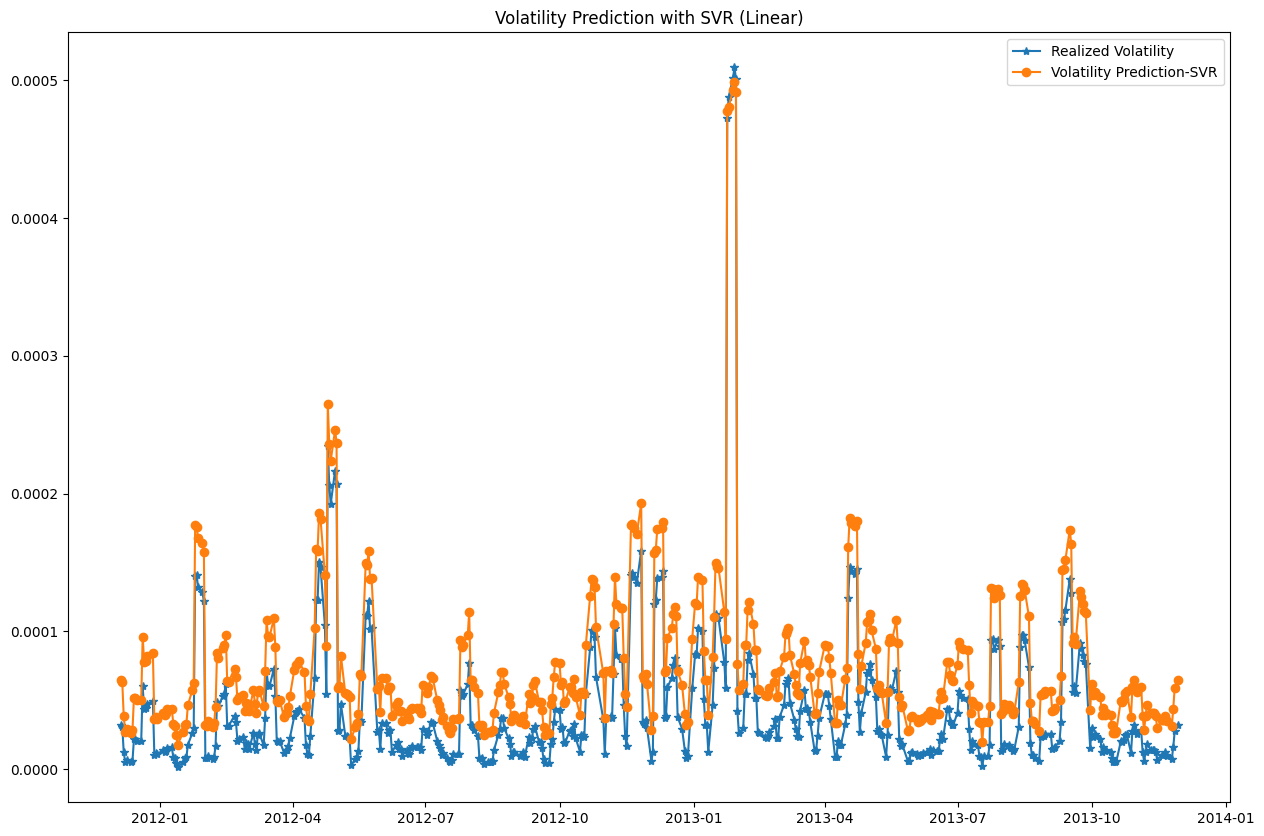

In [246]:
plt.figure(figsize=(15, 10))
plt.plot(realized_vol[-n:]**2 , label='Realized Volatility',marker='*')
plt.plot(predict_svr_lin[-n:]**2 , label='Volatility Prediction-SVR',marker='o')
plt.title('Volatility Prediction with SVR (Linear)', fontsize=12)
plt.legend()
plt.show()

In [242]:
len(realized_vol)

3495

In [243]:
len(predict_svr_lin[-35:])

35

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Frequency [Hz]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 1.0, 'Frequency Response')

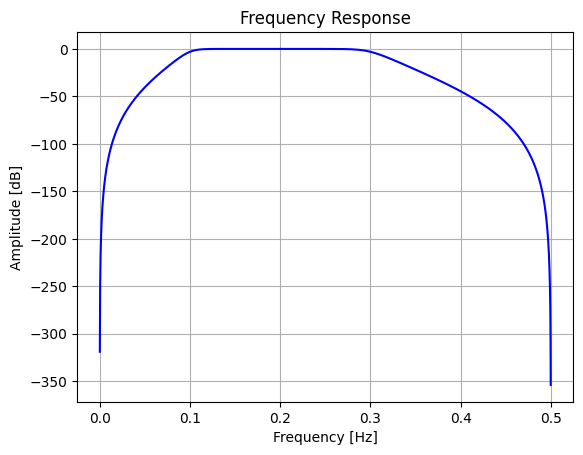

In [261]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Band-pass filter parameters
f1 = 0.1   # Lower cutoff frequency
f2 = 0.3   # Upper cutoff frequency
fs = 1.0   # Sampling frequency

# Create band-pass filter using signal.butter
order = 5  # Filter order
b, a = signal.butter(order, [f1, f2], btype='band', fs=fs)

# Frequency response of the filter
w, h = signal.freqz(b, a, worN=8000)
frequencies = w / (2 * np.pi) * fs

# Plot frequency response
plt.figure()
plt.plot(frequencies, 20 * np.log10(abs(h)), 'b')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('Frequency Response')
plt.grid()
plt.show()